In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import csv
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
import sys
import random
import pandas as pd
from rerank_score_cands_new import load_cands
import numpy as np
from comet import download_model, load_from_checkpoint
import pickle
from sklearn.utils import shuffle


csv.field_size_limit(sys.maxsize)


2022-09-24 04:15:00.541792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 04:15:00.541813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


131072

In [22]:
del model

In [2]:
# Encoder-Decoder Model Embedding, Add a Weighted Layer at the end that leads to regression
class XLMCometRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.1):
        # TODO should we be freezing layers?
        super().__init__()
        
        self.xlmroberta = AutoModel.from_pretrained('xlm-roberta-base')
        # Num labels 1 should just indicate regression (?)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(self.xlmroberta.config.hidden_size, 1), 
        )
        self.to(device)
        
    def forward(self, input_ids, attention_masks):
        # don't finetune xlmroberta model
        #with torch.no_grad():
        word_rep, sentence_rep = self.xlmroberta(input_ids, attention_mask=attention_masks, encoder_attention_mask=attention_masks, return_dict=False)
        # use the first <s> token as a CLS token, TODO experiment with using the sum of 
        # outputs = self.regressor(torch.sum(word_rep, 1))
        outputs = self.regressor(torch.sum(word_rep, 1))
        #print("Shape: ", outputs.shape)
        return outputs
    

model = XLMCometRegressor(drop_rate=0.1)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
model.load_state_dict(torch.load("./torchsaved/comestim.pt"))

<All keys matched successfully>

In [87]:
# data comes from WMT 2019 [I think], TODO validate exact year being used
# data generated with gold reference given as hyp
golddf = pd.read_csv('./processeddata/golddata.csv')
golddf['inp'] = golddf['fr']
golddf['hyp'] = golddf['en']
# data generated on candidates from beam search 50 and lattice (lots of bad)
distill_df = pd.read_csv('distill_cometdata_1.csv')
# data generated between random / unrelated sentences 
rand_df = pd.read_csv('distill_cometdata_rand.csv')[:30000]
# combine
alldf = distill_df.append(rand_df, ignore_index=True)

In [ ]:
del golddf, rand_df, distill_df

In [ ]:
# using XLM roberta for now
xlm_tok = AutoTokenizer.from_pretrained('xlm-roberta-base')
# shuffle data 
alldf = shuffle(alldf)
alldf = alldf.reset_index(drop=True)

In [3]:
# construct inputs from dataframe
def get_inputs(inpdf):
    xinp = []
    yinp = []
    maskinp = []
    
    for index, row in inpdf.iterrows():
        if index%1000==0:
            print(index)
        #print(row['c1'], row['c2'])
        # will need to make a custom mask (maybe) so that inputs from both languages are encoded separately
        toktmp = xlm_tok(row['inp']).input_ids
        lent = len(toktmp)
        hyptmp = xlm_tok(row['hyp']).input_ids
        toktmp.extend(hyptmp)
        mask = torch.zeros(len(toktmp), len(toktmp))
        # should set upper left and bottom right quadrants to 1, mask other stuff
        # TODO make different types of masks. 
        mask[:lent, :lent] = 1
        mask[lent:, lent:] = 1
        xinp.append(toktmp)
        maskinp.append(mask)
        yinp.append(row['scores'])
    return xinp, yinp, maskinp

In [ ]:
# creates masks, tokenized input, and labels in training ready format
xdata, ydata, mdata = get_inputs(alldf)

In [44]:
for i in range(0, len(xtrain)):
    if len(xtrain[i])>500:
        del xtrain[i]
        del ytrain[i]
        del mtrain[i]

IndexError: list index out of range

In [43]:
len(xtrain)

144000

In [5]:
# train test split
cut = int(len(xdata)*.9)
xtrain, ytrain, mtrain = xdata[:cut], ydata[:cut], mdata[:cut]
xtest, ytest, mtest = xdata[cut:], ydata[cut:], mdata[cut:]

In [25]:
xtiny, ytiny, mtiny = xtrain[:10000], ytrain[:10000], mtrain[:10000]

In [4]:
# save all as precaution
def save_cometqe_data(md, xd, yd):
    # save data into a pickle file
    with open('processeddata/commasks.pkl', 'wb') as f:
        pickle.dump(md, f)

    with open('processeddata/cominps.pkl', 'wb') as f:
        pickle.dump(xd, f)

    with open('processeddata/comlabels.pkl', 'wb') as f:
        pickle.dump(yd, f)
        
def load_cometqe_data():
    with open('processeddata/commasks.pkl', 'rb') as f:
        masks = pickle.load(f)

    with open('processeddata/cominps.pkl', 'rb') as f:
        xinps = pickle.load(f)

    with open('processeddata/comlabels.pkl', 'rb') as f:
        yinps = pickle.load(f)
    return masks, xinps, yinps

mdata, xdata, ydata = load_cometqe_data()
        
#save_cometqe_data(mdata, xdata, ydata)

In [6]:
del mdata, xdata, ydata
torch.cuda.empty_cache()

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class RegressionDataset(Dataset):
    def __init__(self, sentences, labels, masks):
        assert len(sentences) == len(labels)
        self.sentences = sentences
        self.labels = labels
        self.masks = masks

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i], self.masks[i]

    def __len__(self):
        return len(self.sentences)

def collate_custom(datafull):
    #print(len(datafull[0]))
    data = [torch.tensor(d[0]) for d in datafull]
    masdata=  [d[2] for d in datafull]
    labels = [d[1] for d in datafull]
    max_len = max([x.squeeze().numel() for x in data])
    data = [torch.nn.functional.pad(x, pad=(0, max_len - x.numel()), mode='constant', value=0) for x in data]
    data = torch.stack(data).to(device)
    # just a normal mask for now
    masdata = [torch.ones_like(m) for m in masdata]
    masdata = [torch.nn.functional.pad(x, pad=(0, max_len - x[0].numel(), 0, max_len - x[0].numel()), mode='constant', value=0) for x in masdata]
    masdata = torch.stack(masdata).to(device)
    return data, torch.tensor(labels).to(device), masdata

testloader = DataLoader(RegressionDataset(xtest, ytest, mtest), batch_size=32, shuffle=True, collate_fn=collate_custom)
trainloader = DataLoader(RegressionDataset(xtrain, ytrain, mtrain), batch_size=32, shuffle=True, collate_fn=collate_custom)

In [8]:
tinyloader = DataLoader(RegressionDataset(xtiny, ytiny, mtiny), batch_size=8, shuffle=True, collate_fn=collate_custom)

NameError: name 'xtiny' is not defined

In [9]:
# hyperparams
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
epochs = 100
total_steps = len(trainloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

loss_function = nn.MSELoss()

In [48]:
max([len(l[0][0]) for l in iter(trainloader)])

403

In [21]:
from torch.nn.utils.clip_grad import clip_grad_norm_
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    print("Total steps :", total_steps)
    best_loss = 1e10
    for epoch in range(epochs):
        if epoch%1==0:
            print("EPOCH ", epoch)
            print("-----")
            print(best_loss)
        model.train()
        cbest = 1e10
        lostot = 0
        loscnt = 0
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_labels, batch_masks = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            #print(outputs.squeeze().shape)
            #print(batch_labels.squeeze().shape)
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            lostot+=loss
            loscnt+=1
            if step%500==0:
                #print(loss)  
                if loscnt>0:
                    print(lostot/loscnt)
                    cbest = min(float(lostot/loscnt), cbest)
                    best_loss = min(best_loss, cbest)
                    print("cbest, ", cbest)
                    if cbest==best_loss:
                        torch.save(model.state_dict(),"torchsaved/comestim"+str(epoch)+".pt")
            #best_loss = min(best_loss, float(loss))
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        cbest = min(float(lostot/loscnt), cbest)
        best_loss = min(best_loss, cbest)
        print("cbest, ", cbest)
        if cbest==best_loss:
            torch.save(model.state_dict(), "torchsaved/comestim"+str(epoch)+".pt")
    return model

def evaluate(model, loss_function, tdataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    preds = []
    ind = 0
    for batch in tdataloader:
        batch_inputs, batch_labels,batch_masks = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
        preds.extend(list(outputs.squeeze()))
        test_loss.append(loss.item())
        #r2 = r2_score(outputs, batch_labels)
        #test_r2.append(r2.item())
        if ind==10:
            print(batch_labels)
            print(outputs)
        ind+=1
    return test_loss, preds

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [35]:
del model 
model = XLMCometRegressor(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/comestim15.pt"))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [36]:
loss = evaluate(model, loss_function, testloader, device)

In [13]:
import math

In [37]:
sloss = [math.sqrt(l) for l in loss[0]]

In [73]:
model = train(model, optimizer, scheduler, loss_function, epochs, 
              trainloader, device, clip_value=2)

Total steps : 450000
EPOCH  0
-----
10000000000.0
tensor(0.0096, device='cuda:3', grad_fn=<DivBackward0>)
cbest,  0.009644205681979656


KeyboardInterrupt: 

In [38]:
nval = [float(l) for l in loss[1]]

(array([292., 161.,  12.,   2.,   6.,   5.,   9.,   8.,   4.,   1.]),
 array([0.05344863, 0.10210352, 0.15075841, 0.1994133 , 0.24806819,
        0.29672308, 0.34537797, 0.39403286, 0.44268775, 0.49134264,
        0.53999753]),
 <BarContainer object of 10 artists>)

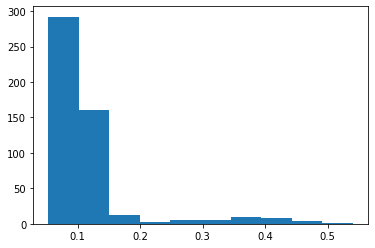

In [40]:
plt.hist(sloss)

In [ ]:
len(ytrain)

In [16]:
import matplotlib.pyplot as plt

(array([  159.,  1468., 11332., 17375.,  2914.,  3905.,  6422., 14571.,
        49381.,  2473.]),
 array([-2.37672544, -2.00800377, -1.63928211, -1.27056044, -0.90183878,
        -0.53311712, -0.16439545,  0.20432621,  0.57304788,  0.94176954,
         1.3104912 ]),
 <BarContainer object of 10 artists>)

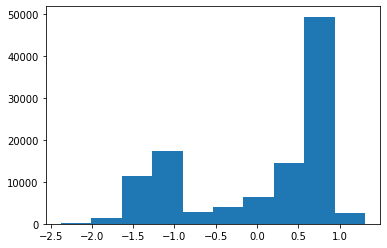

In [88]:
plt.hist(alldf['scores'])